# Question 2

This dataset provides monthly operational metrics for a major Indian airline
from 2013. It includes information on the number of departures, flight hours,
distance flown, passenger traffic, available seat kilometers, freight carried,
and mail carried. You can use any popular time series library for this task.

In [788]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = pd.read_csv('AirtrafficA4.csv')

Removing `null` values out of the data, adding a new `timestamp` column showing month + year in a specific formate.

In [789]:
data['MONTH'] = data['MONTH'].str.strip().replace({ 'JUNE': 'JUN', 'JULY': 'JUL' }).astype(str)
data['YEAR'] = data['YEAR'].astype(str)
data['TIMESTAMP'] = pd.to_datetime(data['YEAR'] + '-' + data['MONTH'] + '-01', format='%Y-%b-%d')
data.fillna(0, inplace=True)

Making `TIMESTAMP` as the index and sorting according to it, so I can plot easily

In [790]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data.set_index('TIMESTAMP', inplace=True)
data = data.asfreq('MS')
data.sort_index(inplace=True)
data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].astype(str).str.replace(',', '').astype(float)
data['COVID PERIOD'] = ((data.index >= '2020-03-01') & (data.index <= '2022-03-01')).astype(bool)
data.to_csv('Temp.csv')

Plotting a graph of passengers carried by the plan each month

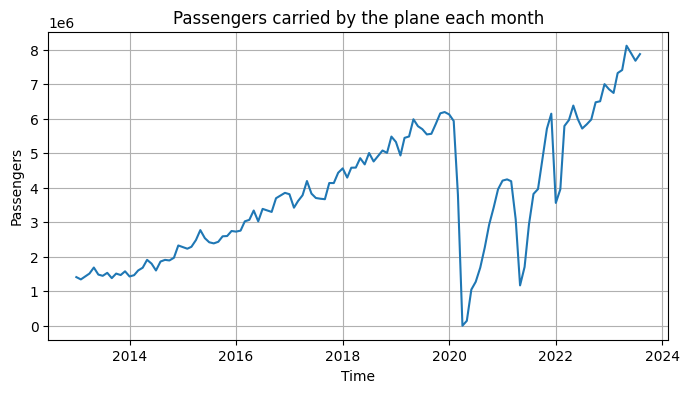

In [791]:
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['PASSENGERS CARRIED'])
plt.title('Passengers carried by the plane each month')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

Let's try interpolating data during COVID

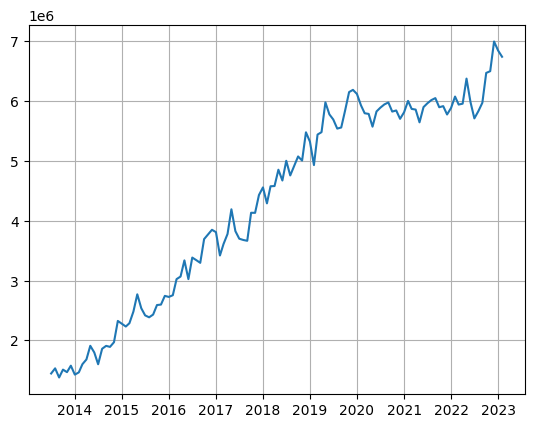

In [792]:
data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].where(~(data['COVID PERIOD']), np.nan)
data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].ffill() 

decomposition = seasonal_decompose(data['PASSENGERS CARRIED'], model='additive', period=12)
seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid

seasonal_interpolated = seasonal.where(~(data['COVID PERIOD']), np.nan).interpolate(method='time')
data['PASSENGERS CARRIED'] = trend + seasonal_interpolated + residual

plt.plot(data.index, data['PASSENGERS CARRIED'])
plt.grid(True)
plt.show()

To remove the trend, we can use differencing. Let's plot the differenced data

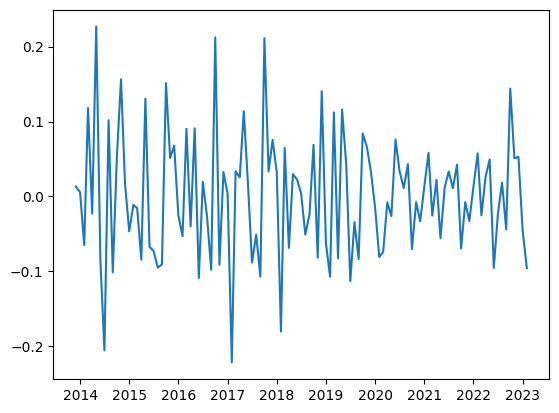

In [793]:
data['LOG_PASSENGERS'] = np.log(data['PASSENGERS CARRIED'].apply(lambda x: x+1 if x == 0 else -x if x < 0 else x))
data['FIRST_DIFF'] = data['LOG_PASSENGERS'].diff(periods=4)
data['DIFF_PASSENGERS'] = data['FIRST_DIFF'].diff()
data.dropna(inplace=True)
plt.plot(data.index, data['DIFF_PASSENGERS'])
plt.show()


Since the data is sorted according to `TIMESTAMP`, let's just split it into training and testing data


In [794]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

train.to_csv('Train.csv')
test.to_csv('Test.csv')

Let's plot ACF, PACF for AR(p) and MA(q) models.

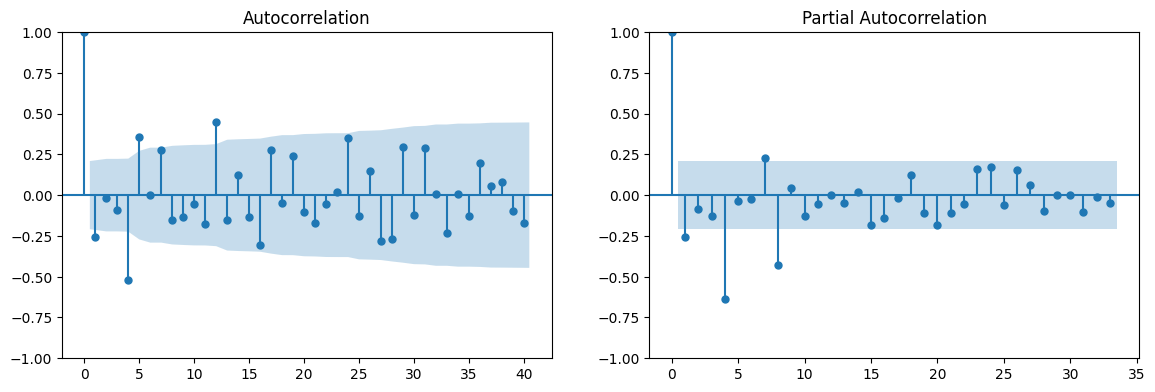

In [795]:
plt.figure(figsize=(120, 50))
plt.subplot(10, 16, 1)
plot_acf(train['DIFF_PASSENGERS'].dropna(), lags=40, ax=plt.gca())
plt.subplot(10, 16, 2)
plot_pacf(train['DIFF_PASSENGERS'].dropna(), lags=33, ax=plt.gca())
plt.show()

Since there is seasonality here, let's try an AutoARIMA model

In [796]:
model = SARIMAX(train['DIFF_PASSENGERS'], order=(0, 1, 0), seasonal_order=(2, 1, 1, 4), freq='MS')
sarima_fit = model.fit(disp=False)

predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / np.abs(y_train.iloc[n - 1] - y_train.iloc[0])

mase_value = mase(test['DIFF_PASSENGERS'], predictions, train['DIFF_PASSENGERS'])
mape_value = np.mean(np.abs((test['DIFF_PASSENGERS'] - predictions) / test['DIFF_PASSENGERS'])) * 100

print(f'Mean Absolute Percentage Error: {mape_value}')
print(f'Mean Absolute Scaled Error: {mase_value}')

Mean Absolute Percentage Error: 87.67056936955349
Mean Absolute Scaled Error: 1.0421518037440507


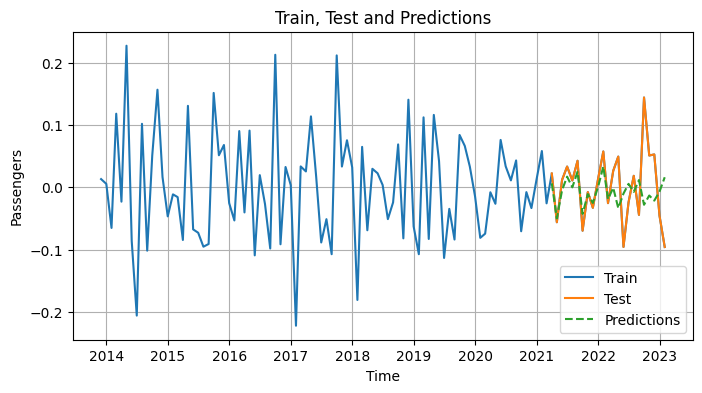

In [797]:
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['DIFF_PASSENGERS'], label='Train')
plt.plot(test.index, test['DIFF_PASSENGERS'], label='Test')
plt.plot(test.index, predictions, label='Predictions', linestyle='--')
plt.title('Train, Test and Predictions')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

Using it to predict the `PASSENGERS CARRIED` from 2023 SEP to 2024 AUG

In [798]:
data_range = pd.date_range(start='2023-09-01', end='2024-08-01', freq='MS')
future_data = pd.DataFrame(index=data_range, columns=['PASSENGERS CARRIED'])

predicted_diffs = sarima_fit.predict(start=len(train), end=len(train) + len(data_range) - 1, dynamic=False)

level_1_diff_reversed = []
level_4_diff_reversed = []

last_log_val4 = data['LOG_PASSENGERS'].iloc[-4:]
last_log_val1 = data['FIRST_DIFF'].iloc[-1]

for i, pred in enumerate(predicted_diffs):
    if i == 0:
        value = pred + last_log_val1
    else:
        value = pred + level_1_diff_reversed[-1]
    level_1_diff_reversed.append(value)
    
print(level_1_diff_reversed)
    
for i, value in enumerate(level_1_diff_reversed):
    if i < 4:
        final_value = value + last_log_val4[i]
    else:
        final_value = value + level_4_diff_reversed[i - 4]
    level_4_diff_reversed.append(final_value)
    
print(level_4_diff_reversed)
    
future_data['PASSENGERS CARRIED'] = [int(np.exp(x) - 1) for x in level_4_diff_reversed]
future_data['YEAR_MONTH'] = future_data.index.strftime('%Y-%b').str.upper()
future_data.to_csv('Future.csv')
future_data = future_data[['YEAR_MONTH', 'PASSENGERS CARRIED']]
future_data.to_csv('Future.csv')
future_data

[0.047353802508915084, -0.0024923630973041414, -0.0071370693148366336, 0.009970813919198523, 0.009912952378023176, 0.0348877530067707, -0.007772978622385657, -0.018642731450923468, -0.043769020428286995, -0.043126193572782245, -0.009922277645845481, -0.028880854824884894]
[15.734805450802787, 15.758567135837355, 15.732240170171812, 15.733830275820743, 15.74471840318081, 15.793454888844126, 15.724467191549426, 15.71518754436982, 15.700949382752523, 15.750328695271344, 15.71454491390358, 15.686306689544935]


/tmp/ipykernel_6899/2859629878.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_value = value + last_log_val4[i]


,YEAR_MONTH,PASSENGERS CARRIED
2023-09-01,2023-SEP,6816149
2023-10-01,2023-OCT,6980052
2023-11-01,2023-NOV,6798686
2023-12-01,2023-DEC,6809505
2024-01-01,2024-JAN,6884053
2024-02-01,2024-FEB,7227868
2024-03-01,2024-MAR,6746045
2024-04-01,2024-APR,6683734
2024-05-01,2024-MAY,6589244
2024-06-01,2024-JUN,6922783
